In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import igpu
import cupy as cp
import pickle

In [2]:
mice = ["mpfc14", "mpfc19", "mpfc20", "mpfc23", "mpfc24", "mpfc30"]
days = ["yd1", "yd1sl", "yd2", "yd2sl", "yd6", "yd6sl"]

In [3]:
x = []
h = []
w = []
for mi, mouse in enumerate(mice):
    ws = []
    hs = []
    xs = []
    for di, day in enumerate(days):
        i = 0
        wss = []
        while True:
            try:
                df = pd.read_csv("no_filt/" + mouse + "_" + day + "_igpu_Wlim001_W" + str(i) + ".csv", header=None).values
                wss.append(df)
                i += 1
            except:
                break
        ws.append(wss)
        hs.append(pd.read_csv("no_filt/" + mouse + "_" + day + "_igpu_Wlim001_H.csv", header=None).values)
        xs.append(pd.read_csv(mouse + "/" + mouse + "_" + day + ".csv", header=None).values)
    w.append(ws)
    h.append(hs)
    x.append(xs)

In [4]:
beh = []
for mi, mouse in enumerate(mice):
    behs = []
    for di, day in enumerate(days):
        if di % 2 == 0:
            df = pd.read_csv("behavior/" + mouse + "/" +mouse + "_" + day + ".csv", header=None).values
        
            n = len(df[:, 0])
            t = np.zeros(n)
            for i in range(1, n-1):
                if df[i, 0] == 1:
                    t[i] = 1
                else:
                    if df[i-1, 0] == 1 and df[i+1, 0] == 1:
                        t[i] = 1
            df[:, 0] = t.copy()
        
            behs.append(df)
        else:
            behs.append(df)
    beh.append(behs)

In [5]:
w_single = []
h_single = []
for mi, _ in enumerate(mice):
    ws = []
    hs = []
    for di, _ in enumerate(days):
        h_tmp = np.zeros_like(h[mi][di])
        t_h = h_tmp.shape[0]
        n, l = w[mi][di][0].shape
        win = l - 1
        win2 = 2 * l - 1
        wss = []
        for wi in range(h[mi][di].shape[1]):
            print(mi, di, wi)
            u = cp.asnumpy(igpu.conv(cp.asarray(w[mi][di][wi][:, cp.newaxis, :]), cp.asarray(h[mi][di][:, wi:wi+1]).T, x[mi][di][x[mi][di] > 0].min()))
            umu = u - u.mean(axis=1)[:, np.newaxis]
            umu2 = umu * umu
            i = u.sum(axis=1).argmax()
            tmp = np.zeros((n, win2))
            for j in range(n):
                if j == i:
                    tmp[i, win] = 1
                    continue
                den2i0 = umu2[i].sum()
                den2j0 = umu2[j].sum()
                if den2j0 == 0:
                    continue
                tmp[j, win] = (umu[i] * umu[j]).sum() / np.sqrt(den2i0 * den2j0)
                den2i = den2i0
                den2j = den2j0
                for p in range(1, l):
                    den2i -= umu2[i, p-1]
                    den2j -= umu2[j, -p]
                    tmp[j, win - p] = (umu[i, p:] * umu[j, :-p]).sum() / np.sqrt(den2i * den2j)
                den2i = den2i0
                den2j = den2j0
                for p in range(1, l):
                    den2i -= umu2[i, -p]
                    den2j -= umu2[j, p-1]
                    tmp[j, win + p] = (umu[i, :-p] * umu[j, p:]).sum() / np.sqrt(den2i * den2j)
            index = tmp.argmax(axis=1)
            index_count = np.array([(index == i).sum() for i in range(win2)])
            scand = np.zeros(win)
            c = index_count[:win].sum()
            for s in range(win):
                c += index_count[s+win]
                scand[s] = c
                c -= index_count[s]
            start = scand.argmax()
            w_pos = tmp[:, start:start+l].argmax(axis=1)
            w_act = u.sum(axis=1) / u.sum()
            h_raw = u / w_act[:, np.newaxis]
            h_count = np.zeros(t_h)
            for i, (a, p) in enumerate(zip(w_act, w_pos)):
                h_tmp[win-p:t_h-p, wi] += a * h_raw[i]
                h_count[win-p:t_h-p] += a
            h_count[h_count == 0] = 1
            h_tmp[:, wi] /= h_count
            wss.append(np.vstack((w_act, w_pos)).T)
        hs.append(h_tmp)
        ws.append(wss)
    h_single.append(hs)
    w_single.append(ws)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 2 0
0 2 1
0 2 2
0 2 3
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 5 0
0 5 1
0 5 2
0 5 3
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 0 5
1 0 6
1 0 7
1 0 8
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 5 0
1 5 1
1 5 2
1 5 3
1 5 4
1 5 5
1 5 6
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 2 5
2 2 6
2 3 0
2 3 1
2 3 2
2 3 3
2 3 4
2 3 5
2 3 6
2 4 0
2 4 1
2 4 2
2 4 3
2 4 4
2 4 5
2 4 6
2 4 7
2 5 0
2 5 1
2 5 2
2 5 3
2 5 4
2 5 5
2 5 6
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 0 5
3 0 6
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 1 5
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 2 5
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 4 0
3 4 1
3 4 2
3 4 3
3 4 4
3 4 5
3 4 6
3 5 0
3 5 1
3 5 2
3 5 3
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 1 0
4 1 1
4 1 2
4 1 3
4 2 0
4 2 1
4 2 2
4 2 3
4 2 4
4 2 

In [6]:
with open("no_filt/w_single_Wlim001.pkl", "wb") as f:
    pickle.dump(w_single, f)
with open("no_filt/h_single_Wlim001.pkl", "wb") as f:
    pickle.dump(h_single, f)

In [7]:
h_spike = []
for mi, mouse in enumerate(mice):
    spikes = []
    for di, day in enumerate(days):
        move_ave = np.zeros_like(h_single[mi][di])
        s = h_single[mi][di][:49].sum(axis=0)
        num = 49
        # s = np.zeros(h_single[mi][di].shape[1])
        # num = 0
        t = move_ave.shape[0]
        for i in range(t):
            if i + 49 < t:
                num += 1
                s[:] += h_single[mi][di][i+49, :]
            # num += 1
            # s[:] += h_single[mi][di][i, :]
            move_ave[i, :] = s[:] / num
            if i - 49 > 0:
                num -= 1
                s[:] -= h_single[mi][di][i-49, :]
        tmp = h_single[mi][di] - move_ave
        tmp[tmp < 0] = 0
        th =  tmp.mean(axis=0) + 2 * tmp.std(axis=0)
        for i, thi in enumerate(th):
            tmp[:, i][tmp[:, i] > thi] = thi
            tmp[:, i] /= thi
        spikes.append(tmp)
    h_spike.append(spikes)

In [18]:
with open("no_filt/h_spike_Wlim001_alt2.pkl", "wb") as f:
    pickle.dump(h_spike, f)

In [76]:
h_spike = []
for mi, mouse in enumerate(mice):
    spikes = []
    for di, day in enumerate(days):
        move_ave = np.zeros_like(h_single[mi][di])
        s = h_single[mi][di][:49].sum(axis=0)
        num = 49
        # s = np.zeros(h_single[mi][di].shape[1])
        # num = 0
        t = move_ave.shape[0]
        for i in range(t):
            if i + 49 < t:
                num += 1
                s[:] += h_single[mi][di][i+49, :]
            # num += 1
            # s[:] += h_single[mi][di][i, :]
            move_ave[i, :] = s[:] / num
            if i - 49 > 0:
                num -= 1
                s[:] -= h_single[mi][di][i-49, :]
        tmp = (h_single[mi][di] - move_ave) / move_ave
        tmp[tmp < 0] = 0
        th =  tmp.mean(axis=0) + 2 * tmp.std(axis=0)
        for i, thi in enumerate(th):
            tmp[:, i][tmp[:, i] > thi] = thi
            tmp[:, i] /= thi
        spikes.append(tmp)
    h_spike.append(spikes)

In [77]:
with open("no_filt/h_spike_Wlim001.pkl", "wb") as f:
    pickle.dump(h_spike, f)

In [78]:
h_spike = []
for mi, mouse in enumerate(mice):
    spikes = []
    for di, day in enumerate(days):
        move_ave = np.zeros_like(h_single[mi][di])
        # s = h_single[mi][di][:49].sum(axis=0)
        # num = 49
        s = np.zeros(h_single[mi][di].shape[1])
        num = 0
        t = move_ave.shape[0]
        for i in range(t):
            # if i + 49 < t:
            #     num += 1
            #     s[:] += h_single[mi][di][i+49, :]
            num += 1
            s[:] += h_single[mi][di][i, :]
            move_ave[i, :] = s[:] / num
            if i - 49 > 0:
                num -= 1
                s[:] -= h_single[mi][di][i-49, :]
        tmp = (h_single[mi][di] - move_ave) / move_ave
        tmp[tmp < 0] = 0
        th =  tmp.mean(axis=0) + 2 * tmp.std(axis=0)
        for i, thi in enumerate(th):
            tmp[:, i][tmp[:, i] > thi] = thi
            tmp[:, i] /= thi
        spikes.append(tmp)
    h_spike.append(spikes)

In [79]:
with open("no_filt/h_spike_Wlim001_alt.pkl", "wb") as f:
    pickle.dump(h_spike, f)

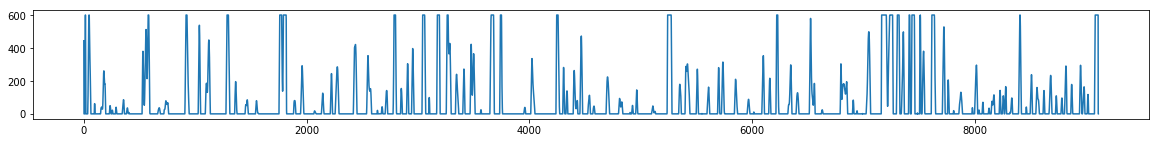

In [16]:
plt.figure(figsize=(20, 2))
#plt.plot(h[4][4][:, 2])
plt.plot(h_spike[4][4][:, 2] * 600)

(0, 10)

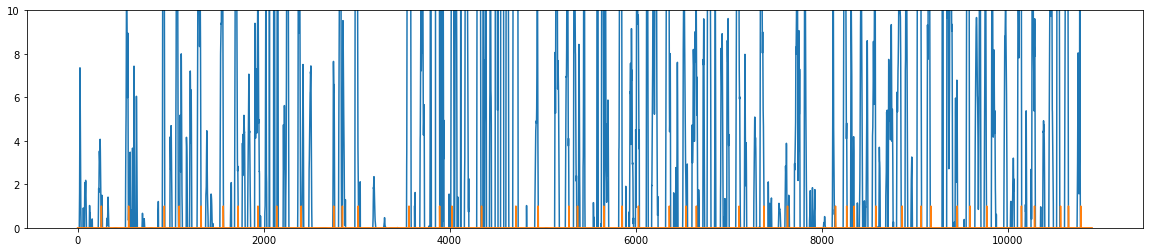

0.9989174961573397

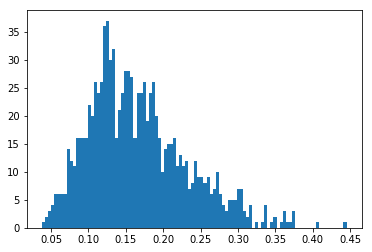

0.004318363171765268

0.16591637723756383

0.16494123675162933

0.00434697750782713

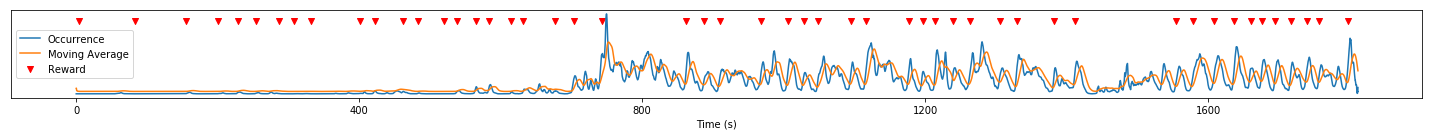

In [59]:
mi = 4
di = 4
move_ave = np.zeros_like(h_single[mi][di])
# s = h_single[mi][di][:49].sum(axis=0)
# num = 49
s = np.zeros(h_single[mi][di].shape[1])
num = 0
t = move_ave.shape[0]
for i in range(t):
    # if i + 49 < t:
    #     num += 1
    #     s[:] += h_single[mi][di][i+49, :]
    num += 1
    s[:] += h_single[mi][di][i, :]
    move_ave[i, :] = s[:] / num
    if i - 49 > 0:
        num -= 1
        s[:] -= h_single[mi][di][i-49, :]
plt.figure(figsize=(20, 2))
plt.plot(h_single[mi][di][49:, 1], label="Occurrence")
plt.plot(move_ave[49:, 1], label="Moving Average")
plt.scatter(np.where(beh[mi][di][:, 2] == 1), np.ones(int(beh[mi][di][:, 2].sum())) * 300, marker="v", c="r", label="Reward")
plt.legend()
plt.yticks([])
plt.xticks([2000 * i for i in range(5)], [400 * i for i in range(5)])
plt.xlabel("Time (s)")
plt.tight_layout()

In [60]:
tmp = (h_single[mi][di][49:, 1] - move_ave[49:, 1]) / move_ave[49:, 1]
tmp[tmp < 0] = 0

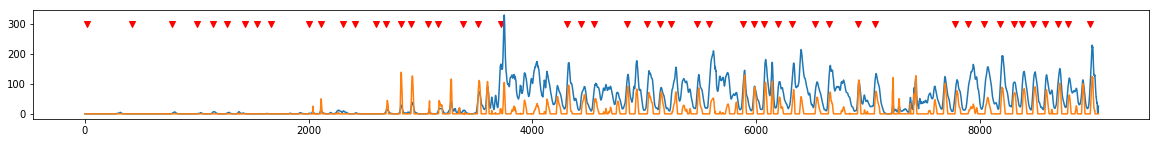

In [58]:
plt.figure(figsize=(20, 2))
plt.plot(h_single[mi][di][49:, 1])
plt.plot(tmp * 100)
plt.scatter(np.where(beh[mi][di][:, 2] == 1), np.ones(int(beh[mi][di][:, 2].sum())) * 300, marker="v", c="r", label="Reward")

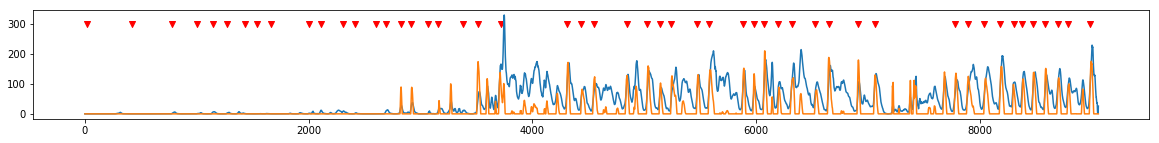

In [61]:
plt.figure(figsize=(20, 2))
plt.plot(h_single[mi][di][49:, 1])
plt.plot(tmp * 100)
plt.scatter(np.where(beh[mi][di][:, 2] == 1), np.ones(int(beh[mi][di][:, 2].sum())) * 300, marker="v", c="r", label="Reward")

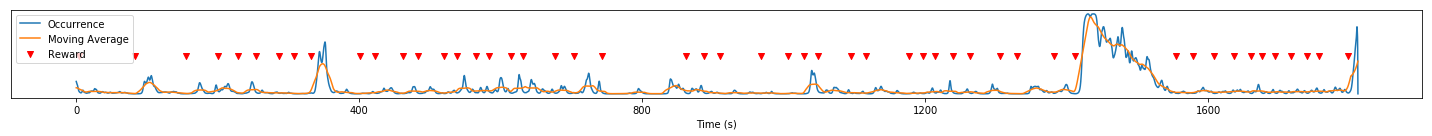

In [261]:
mi = 4
di = 4
move_ave = np.zeros_like(h_single[mi][di])
s = h_single[mi][di][:49].sum(axis=0)
num = 49
t = move_ave.shape[0]
for i in range(t):
    if i + 49 < t:
        num += 1
        s[:] += h_single[mi][di][i+49, :]
    move_ave[i, :] = s[:] / num
    if i - 49 > 0:
        num -= 1
        s[:] -= h_single[mi][di][i-49, :]
plt.figure(figsize=(20, 2))
plt.plot(h_single[mi][di][49:, 2], label="Occurrence")
plt.plot(move_ave[49:, 2], label="Moving Average")
plt.scatter(np.where(beh[mi][di][:, 2] == 1), np.ones(int(beh[mi][di][:, 2].sum())) * 300, marker="v", c="r", label="Reward")
plt.legend()
plt.yticks([])
plt.xticks([2000 * i for i in range(5)], [400 * i for i in range(5)])
plt.xlabel("Time (s)")
plt.tight_layout()
plt.savefig("fig3_moving_average.png")

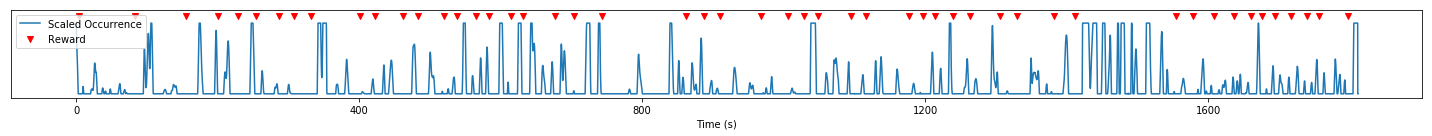

In [17]:
plt.figure(figsize=(20, 2))
plt.plot(h_spike[4][4][49:, 2], label="Scaled Occurrence")
plt.scatter(np.where(beh[4][4][:, 2] == 1), np.ones(int(beh[4][4][:, 2].sum())) * 1.1, marker="v", c="r", label="Reward")
plt.legend()
plt.yticks([])
plt.xticks([2000 * i for i in range(5)], [400 * i for i in range(5)])
plt.xlabel("Time (s)")
plt.tight_layout()
plt.savefig("fig3_scaled_occurrence.png")

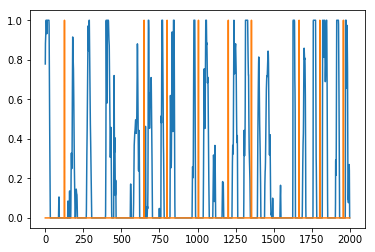

In [244]:
plt.plot(h_spike[0][4][1049:3049, 1])
plt.plot(beh[0][4][1000:3000, 2])

In [87]:
mu = np.array([x[0][0][300*i:300*(i+1), :].mean(axis=0) for i in range(x[0][0].shape[0] // 300)])

In [92]:
sigma = np.array([x[0][0][300*i:300*(i+1), :].std(axis=0) for i in range(x[0][0].shape[0] // 300)])

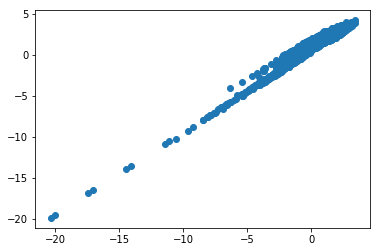

In [95]:
plt.scatter(np.log(mu.reshape(-1)), np.log(sigma.reshape(-1)))